# Mask R-CNN - Inspect Balloon Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
os.chdir('D:\Machine Learning\Paper\Object Detection\Mask_RCNN-master')
import sys

In [2]:
sys.path.append('D:\Machine Learning\Paper\Object Detection\Mask_RCNN-master')

sys.path.append('D:\Machine Learning\Paper\Object Detection\Mask_RCNN-master\samples\balloon')

In [3]:
import scipy
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/balloon"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import balloon

%matplotlib inline 

D:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

Configurations are defined in balloon.py

In [4]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")

In [5]:
ROOT_DIR

'D:\\Machine Learning\\Paper\\Object Detection\\Mask_RCNN-master'

## Dataset

In [6]:
dataset_dir = BALLOON_DIR

In [7]:
dataset_dir = os.path.join(dataset_dir, 'train')

In [8]:
# We mostly care about the x and y coordinates of each region
annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))

In [9]:
annotations = list(annotations.values())  # don't need the dict keys

In [10]:
# The VIA tool saves images in the JSON even if they don't have any
# annotations. Skip unannotated images.
annotations = [a for a in annotations if a['regions']]

In [11]:
import skimage

In [12]:
a = annotations[20]

In [13]:
# Get the x, y coordinaets of points of the polygons that make up
# the outline of each object instance. There are stores in the
# shape_attributes (see json format above)
polygons = [r['shape_attributes'] for r in a['regions'].values()]

In [14]:
# load_mask() needs the image size to convert polygons to masks.
# Unfortunately, VIA doesn't include it in JSON, so we must read
# the image. This is only managable since the dataset is tiny.
image_path = os.path.join(dataset_dir, a['filename'])

In [15]:
image = skimage.io.imread(image_path)
height, width = image.shape[:2]

In [16]:
height, width

(1365, 2048)

In [17]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 61
Class Count: 2
  0. BG                                                
  1. balloon                                           


## Display Samples

Load and display images and masks.

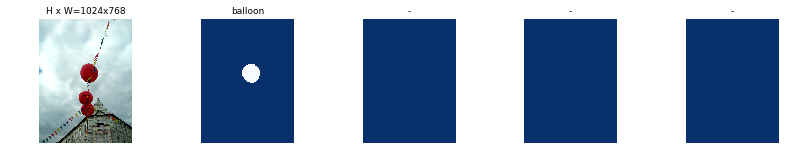

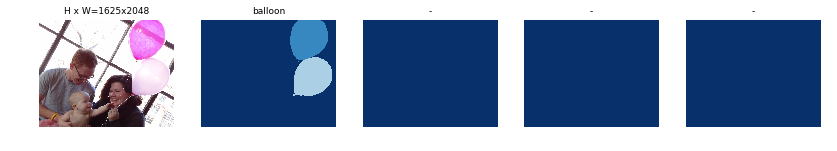

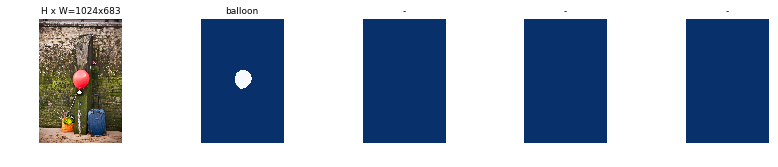

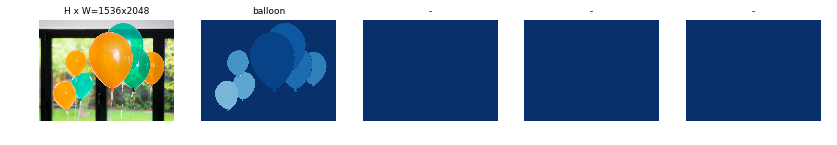

In [18]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

In [19]:
def extract_bboxes(mask):
    #从mask当中提取bbox,原因上面已经说了
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        #横轴上只要有一行有一个点不是0，就把这一行的序号记录下来
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        #纵轴上只要有一行有一个点不是0，就把这一行的序号记录下来
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            #分别取横轴和纵轴的最大和最小
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            #不明白，感觉没什么影响啊，那为什么x1 -= 1,y1-=1 ？？？"}
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            #如果因为任何操作把bounding box破坏了，就输出全0的bbox
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

image_id  54 D:\Machine Learning\Paper\Object Detection\Mask_RCNN-master\datasets/balloon\train\321888854_3723b6f10b_b.jpg
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000
mask                     shape: (768, 1024, 3)        min:    0.00000  max:    1.00000
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000
bbox                     shape: (3, 4)                min:  114.00000  max:  759.00000


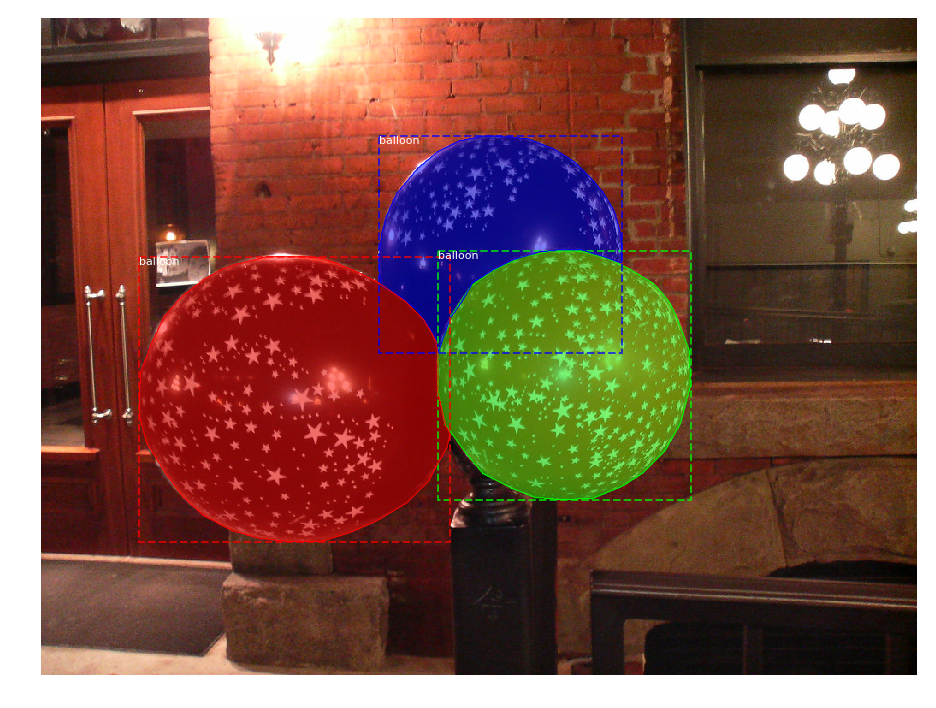

In [20]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

In [21]:
config.IMAGE_MIN_DIM

800

In [22]:
config.IMAGE_MAX_DIM

1024

In [23]:
config.IMAGE_PADDING

True

In [24]:
def resize_image(image, min_dim=None, max_dim=None, padding=False):
    """
    Resizes an image keeping the aspect ratio.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    padding: If true, pads image with zeros so it's size is max_dim x max_dim

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    # Does it exceed max dim?
    if max_dim:
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max
    # Resize image and mask
    if scale != 1:
        image = scipy.misc.imresize(
            image, (round(h * scale), round(w * scale)))
    # Need padding?
    if padding:
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    return image, window, scale, padding

In [25]:
def resize_mask(mask, scale, padding):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.

    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    h, w = mask.shape[:2]
    #上采样的方式参见https://blog.csdn.net/jiandanjinxin/article/details/72356271
    mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask

image_id:  42 D:\Machine Learning\Paper\Object Detection\Mask_RCNN-master\datasets/balloon\train\2385899600_94b68350af_b.jpg
Original shape:  (576, 1024, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:  272.00000  max:  985.00000


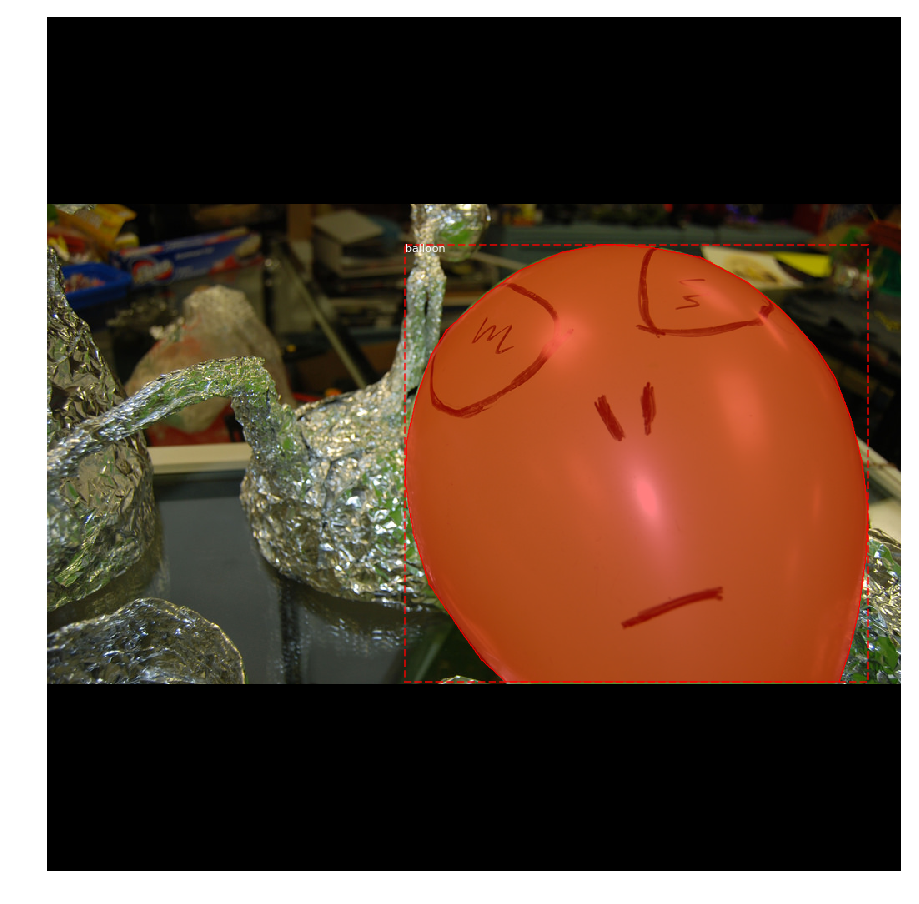

In [26]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    padding=config.IMAGE_PADDING)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

In [27]:
def load_image_gt(dataset, config, image_id, augment=False,
                  use_mini_mask=False):
    """Load and return ground truth data for an image (image, mask, bounding boxes).

    augment: If true, apply random image augmentation. Currently, only
        horizontal flipping is offered.
    use_mini_mask: If False, returns full-size masks that are the same height
        and width as the original image. These can be big, for example
        1024x1024x100 (for 100 instances). Mini masks are smaller, typically,
        224x224 and are generated by extracting the bounding box of the
        object and resizing it to MINI_MASK_SHAPE.

    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    shape = image.shape
    image, window, scale, padding = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        max_dim=config.IMAGE_MAX_DIM,
        padding=config.IMAGE_PADDING)
    #按相同比例和padding缩放mask
    mask = utils.resize_mask(mask, scale, padding)

    # Random horizontal flips.
    if augment:
        if random.randint(0, 1):
            # np.fliplr起到左右翻转的作用
            image = np.fliplr(image)
            mask = np.fliplr(mask)

    # Note that some boxes might be all zeros if the corresponding mask got cropped out.
    # and here is to filter them out
    _idx = np.sum(mask, axis=(0, 1)) > 0
    mask = mask[:, :, _idx]
    class_ids = class_ids[_idx]
    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    bbox = utils.extract_bboxes(mask)

    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if use_mini_mask:
        mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)

    # Image meta data
    image_meta = compose_image_meta(image_id, shape, window, active_class_ids)

    return image, image_meta, class_ids, bbox, mask

In [28]:
def minimize_mask(bbox, mask, mini_shape):
    """Resize masks to a smaller version to cut memory load.
    Mini-masks can then resized back to image scale using expand_masks()

    See inspect_data.ipynb notebook for more details.
    """
    mini_mask = np.zeros(mini_shape + (mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        #bbox的左上和右下
        y1, x1, y2, x2 = bbox[i][:4]
        #把mask给圈在bbox里了，抛弃了外面的0，是因为这个所以之前extract_bboxes里面要x2+=1,y2+=1嘛 ？
        m = m[y1:y2, x1:x2]
        if m.size == 0:
            raise Exception("Invalid bounding box with area of zero")
        #把mask缩小到config.MINI_MASK_SHAPE
        m = scipy.misc.imresize(m.astype(float), mini_shape, interp='bilinear')
        mini_mask[:, :, i] = np.where(m >= 128, 1, 0)
    return mini_mask

In [29]:
def compose_image_meta(image_id, image_shape, window, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    image_shape: [height, width, channels]
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +            # size=1
        list(image_shape) +     # size=3
        list(window) +          # size=4 (y1, x1, y2, x2) in image cooredinates
        list(active_class_ids)  # size=num_classes
    )
    return meta

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:  316.00000  max:  907.00000
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000


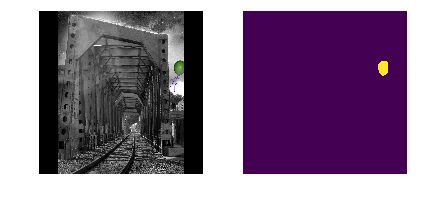

In [30]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

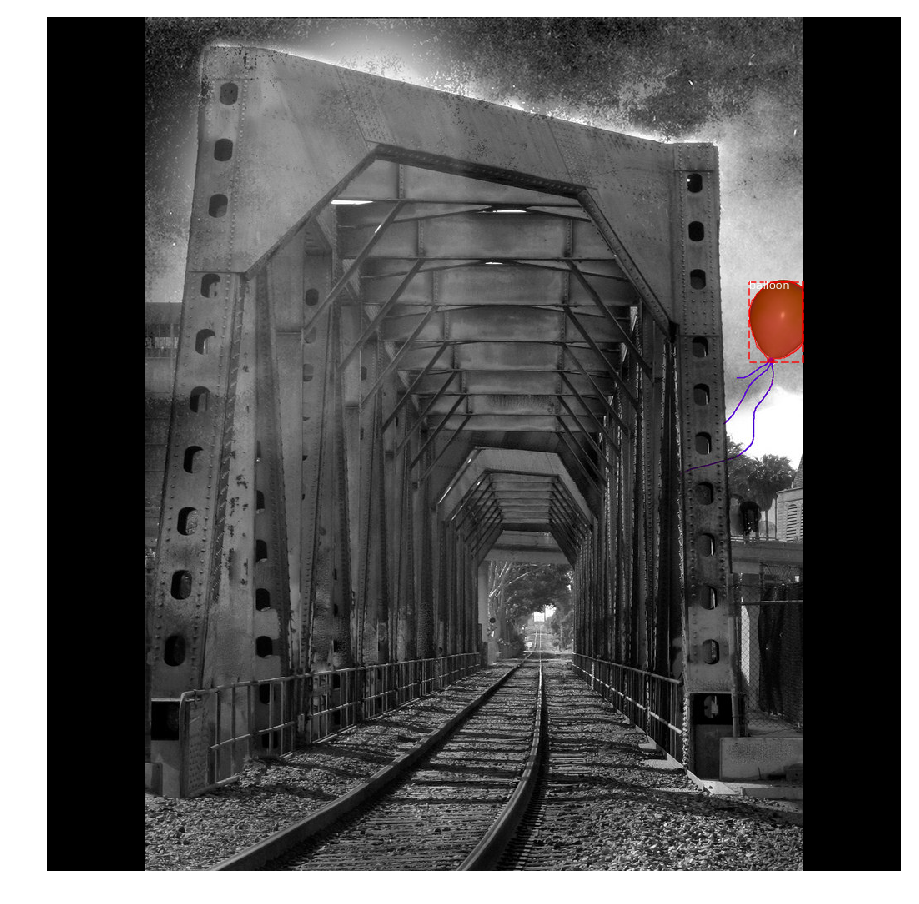

In [31]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000


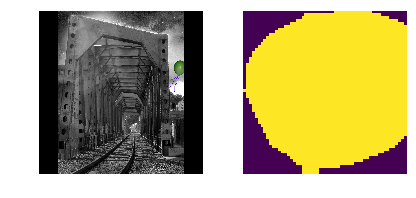

In [32]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [33]:
def expand_mask(bbox, mini_mask, image_shape):
    """Resizes mini masks back to image size. Reverses the change
    of minimize_mask().

    See inspect_data.ipynb notebook for more details.
    """
    #先制造全0的一张图
    mask = np.zeros(image_shape[:2] + (mini_mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        m = mini_mask[:, :, i]
        y1, x1, y2, x2 = bbox[i][:4]
        h = y2 - y1
        w = x2 - x1
        #算出bbox高和宽
        #再把mask还原到原尺寸的bbox里面去
        #interpolation这里用bilinear,感觉边缘效果会好一些
        m = scipy.misc.imresize(m.astype(float), (h, w), interp='bilinear')
        #再在全0的图上面把mask贴上去
        mask[y1:y2, x1:x2, i] = np.where(m >= 128, 1, 0)
    return mask

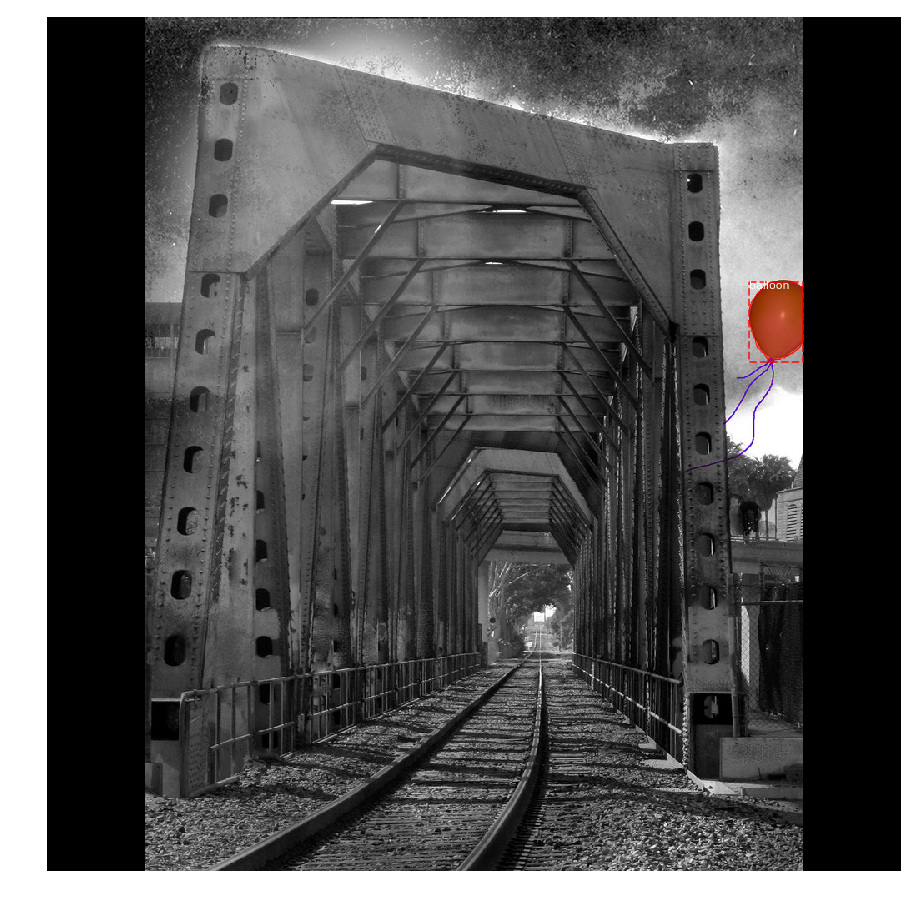

In [34]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [35]:
scales = config.RPN_ANCHOR_SCALES
scales

(32, 64, 128, 256, 512)

In [36]:
ratios = config.RPN_ANCHOR_RATIOS
ratios

[0.5, 1, 2]

In [37]:
(256*256 + 128*128 + 64*64 + 32* 32 + 16*16)*3

261888

In [38]:
feature_shapes = config.BACKBONE_SHAPES
feature_shapes

array([[256, 256],
       [128, 128],
       [ 64,  64],
       [ 32,  32],
       [ 16,  16]])

In [39]:
feature_strides = config.BACKBONE_STRIDES
feature_strides

[4, 8, 16, 32, 64]

In [40]:
anchor_stride = config.RPN_ANCHOR_STRIDE
anchor_stride

1

In [41]:
def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)

In [42]:
def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    #np.meshgrid : https://zhuanlan.zhihu.com/p/29663486
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()
    #穷举所有可能的scale和ratio的组合

    # Enumerate heights and widths from scales and ratios
    # 穷举所有高和宽
    # 进而就穷举了所有的anchor尺寸，但是还没有在feature map上扫描
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    # 穷举所有扫描的位移
    # 这样理解下面的操作，以第一层为例（最底层）1024 = 256 * 4
    # 所以最底下一层的feature map是256 * 256，
    # feature map上每移动一格，相当于原图上移动4个像素
    # 如果算当前这个feature map上一个点的感受野，只有4*4
    # 这里假定这个anchor size要比感受野大，32
    # 所以如下的操作相当于在原图上用32*32（还要其它ratio）的anchor
    # 以4的步长一步一步扫描过整张图
    # 这样会有一些重叠，但是可以想见性能会有提示。
    # 总共有 256 * 256 * 3 = 196608 个 anchors !
    # 我记得论文里说可以用金字塔，但相比单层提取提升性能不多
    # 当 feature map是 16 * 16时，feature stride=64
    # 此时feature map上每移动一格，相当于原图上移动64个像素
    # 但是此时用的anchor size是512，相当于整张图的一半
    # 那也有 16 * 16 * 3 = 768 个 滑动anchors
    # 这么多不同尺度的累加，性能必须好啊
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    # 假定偏移了feature_stride之后的点就是中心点，再穷举宽，高
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    # 巧妙的先stack成三维，再reshape成两维，正好就把x,y配成了一对
    # 反正我是写不出来
    box_centers = np.stack([box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    # 把中心点+宽高 转换成 左上，右下的坐标
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes

In [43]:
# Generate Anchors
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          config.BACKBONE_SHAPES,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(config.BACKBONE_SHAPES)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = config.BACKBONE_SHAPES[l][0] * config.BACKBONE_SHAPES[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


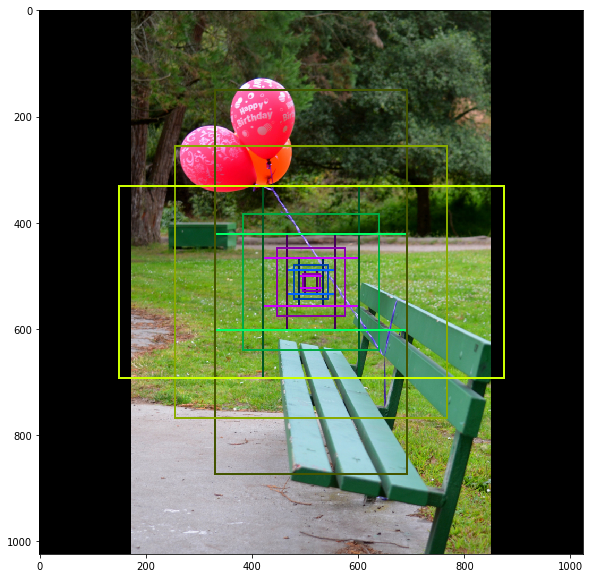

In [44]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(config.BACKBONE_SHAPES)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                config.BACKBONE_SHAPES[level]))
    center_cell = config.BACKBONE_SHAPES[level] // 2
    center_cell_index = (center_cell[0] * config.BACKBONE_SHAPES[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * config.BACKBONE_SHAPES[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [45]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [46]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [47]:
def data_generator(dataset, config, shuffle=True, augment=True, random_rois=0,
                   batch_size=1, detection_targets=False):
    """A generator that returns images and corresponding target class ids,
    bounding box deltas, and masks.

    dataset: The Dataset object to pick data from
    config: The model config object
    shuffle: If True, shuffles the samples before every epoch
    augment: If True, applies image augmentation to images (currently only
             horizontal flips are supported)
    random_rois: If > 0 then generate proposals to be used to train the
                 network classifier and mask heads. Useful if training
                 the Mask RCNN part without the RPN.
    batch_size: How many images to return in each call
    detection_targets: If True, generate detection targets (class IDs, bbox
        deltas, and masks). Typically for debugging or visualizations because
        in trainig detection targets are generated by DetectionTargetLayer.

    Returns a Python generator. Upon calling next() on it, the
    generator returns two lists, inputs and outputs. The containtes
    of the lists differs depending on the received arguments:
    inputs list:
    - images: [batch, H, W, C]
    - image_meta: [batch, size of image meta]
    - rpn_match: [batch, N] Integer (1=positive anchor, -1=negative, 0=neutral)
    - rpn_bbox: [batch, N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    - gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs
    - gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)]
    - gt_masks: [batch, height, width, MAX_GT_INSTANCES]. The height and width
                are those of the image unless use_mini_mask is True, in which
                case they are defined in MINI_MASK_SHAPE.

    outputs list: Usually empty in regular training. But if detection_targets
        is True then the outputs list contains target class_ids, bbox deltas,
        and masks.
    """
    b = 0  # batch item index
    image_index = -1
    image_ids = np.copy(dataset.image_ids)
    error_count = 0

    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    # 产生261888个anchor
    anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                             config.RPN_ANCHOR_RATIOS,
                                             config.BACKBONE_SHAPES,
                                             config.BACKBONE_STRIDES,
                                             config.RPN_ANCHOR_STRIDE)

    # Keras requires a generator to run indefinately.
    while True:
        try:
            # Increment index to pick next image. Shuffle if at the start of an epoch.
            image_index = (image_index + 1) % len(image_ids)
            # 取完一遍所有图片以后就shuffle
            if shuffle and image_index == 0:
                np.random.shuffle(image_ids)

            # Get GT bounding boxes and masks for image.
            image_id = image_ids[image_index]
            # 这个函数前面有分析
            # 其实整体dataloader的逻辑是一张一张的图片取如下几个数据，
            # 取够了batch_size就yield
            image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(dataset, config, image_id, augment=augment,
                              use_mini_mask=config.USE_MINI_MASK)

            # Skip images that have no instances. This can happen in cases
            # where we train on a subset of classes and the image doesn't
            # have any of the classes we care about.
            if not np.any(gt_class_ids > 0):
                continue

            # RPN Targets
            rpn_match, rpn_bbox = build_rpn_targets(image.shape, anchors,
                                                    gt_class_ids, gt_boxes, config)

            # Mask R-CNN Targets
            if random_rois:
                rpn_rois = generate_random_rois(
                    image.shape, random_rois, gt_class_ids, gt_boxes)
                if detection_targets:
                    rois, mrcnn_class_ids, mrcnn_bbox, mrcnn_mask =\
                        build_detection_targets(
                            rpn_rois, gt_class_ids, gt_boxes, gt_masks, config)

            # Init batch arrays
            if b == 0:
                batch_image_meta = np.zeros(
                    (batch_size,) + image_meta.shape, dtype=image_meta.dtype)
                batch_rpn_match = np.zeros(
                    [batch_size, anchors.shape[0], 1], dtype=rpn_match.dtype)
                batch_rpn_bbox = np.zeros(
                    [batch_size, config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
                batch_images = np.zeros(
                    (batch_size,) + image.shape, dtype=np.float32)
                batch_gt_class_ids = np.zeros(
                    (batch_size, config.MAX_GT_INSTANCES), dtype=np.int32)
                batch_gt_boxes = np.zeros(
                    (batch_size, config.MAX_GT_INSTANCES, 4), dtype=np.int32)
                if config.USE_MINI_MASK:
                    batch_gt_masks = np.zeros((batch_size, config.MINI_MASK_SHAPE[0], config.MINI_MASK_SHAPE[1],
                                               config.MAX_GT_INSTANCES))
                else:
                    batch_gt_masks = np.zeros(
                        (batch_size, image.shape[0], image.shape[1], config.MAX_GT_INSTANCES))
                if random_rois:
                    batch_rpn_rois = np.zeros(
                        (batch_size, rpn_rois.shape[0], 4), dtype=rpn_rois.dtype)
                    if detection_targets:
                        batch_rois = np.zeros(
                            (batch_size,) + rois.shape, dtype=rois.dtype)
                        batch_mrcnn_class_ids = np.zeros(
                            (batch_size,) + mrcnn_class_ids.shape, dtype=mrcnn_class_ids.dtype)
                        batch_mrcnn_bbox = np.zeros(
                            (batch_size,) + mrcnn_bbox.shape, dtype=mrcnn_bbox.dtype)
                        batch_mrcnn_mask = np.zeros(
                            (batch_size,) + mrcnn_mask.shape, dtype=mrcnn_mask.dtype)

            # If more instances than fits in the array, sub-sample from them.
            # default config.MAX_GT_INSTANCES = 100
            if gt_boxes.shape[0] > config.MAX_GT_INSTANCES:
                ids = np.random.choice(
                    np.arange(gt_boxes.shape[0]), config.MAX_GT_INSTANCES, replace=False)
                gt_class_ids = gt_class_ids[ids]
                gt_boxes = gt_boxes[ids]
                gt_masks = gt_masks[:, :, ids]

            # Add to batch
            batch_image_meta[b] = image_meta
            batch_rpn_match[b] = rpn_match[:, np.newaxis]
            batch_rpn_bbox[b] = rpn_bbox
            batch_images[b] = mold_image(image.astype(np.float32), config)
            batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
            batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
            batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
            if random_rois:
                batch_rpn_rois[b] = rpn_rois
                if detection_targets:
                    batch_rois[b] = rois
                    batch_mrcnn_class_ids[b] = mrcnn_class_ids
                    batch_mrcnn_bbox[b] = mrcnn_bbox
                    batch_mrcnn_mask[b] = mrcnn_mask
            b += 1

            # Batch full?
            if b >= batch_size:
                inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
                          batch_gt_class_ids, batch_gt_boxes, batch_gt_masks]
                outputs = []

                if random_rois:
                    inputs.extend([batch_rpn_rois])
                    if detection_targets:
                        inputs.extend([batch_rois])
                        # Keras requires that output and targets have the same number of dimensions
                        batch_mrcnn_class_ids = np.expand_dims(
                            batch_mrcnn_class_ids, -1)
                        outputs.extend(
                            [batch_mrcnn_class_ids, batch_mrcnn_bbox, batch_mrcnn_mask])

                yield inputs, outputs

                # start a new batch
                b = 0
        except (GeneratorExit, KeyboardInterrupt):
            raise
        except:
            # Log it and skip the image
            logging.exception("Error processing image {}".format(
                dataset.image_info[image_id]))
            error_count += 1
            if error_count > 5:
                raise

In [48]:
def build_rpn_targets(image_shape, anchors, gt_class_ids, gt_boxes, config):
    """Given the anchors and GT boxes, compute overlaps and identify positive
    anchors and deltas to refine them to match their corresponding GT boxes.

    anchors: [num_anchors, (y1, x1, y2, x2)]
    gt_class_ids: [num_gt_boxes] Integer class IDs.
    gt_boxes: [num_gt_boxes, (y1, x1, y2, x2)]

    Returns:
    rpn_match: [N] (int32) matches between anchors and GT boxes.
               1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_bbox: [N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    """
    # RPN Match: 1 = positive anchor, -1 = negative anchor, 0 = neutral
    rpn_match = np.zeros([anchors.shape[0]], dtype=np.int32)
    # RPN bounding boxes: [max anchors per image, (dy, dx, log(dh), log(dw))]
    rpn_bbox = np.zeros((config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4))

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = np.where(gt_class_ids < 0)[0]
    if crowd_ix.shape[0] > 0:
        # Filter out crowds from ground truth class IDs and boxes
        non_crowd_ix = np.where(gt_class_ids > 0)[0]
        crowd_boxes = gt_boxes[crowd_ix]
        gt_class_ids = gt_class_ids[non_crowd_ix]
        gt_boxes = gt_boxes[non_crowd_ix]
        # Compute overlaps with crowd boxes [anchors, crowds]
        crowd_overlaps = utils.compute_overlaps(anchors, crowd_boxes)
        crowd_iou_max = np.amax(crowd_overlaps, axis=1)
        no_crowd_bool = (crowd_iou_max < 0.001)
    else:
        # All anchors don't intersect a crowd
        no_crowd_bool = np.ones([anchors.shape[0]], dtype=bool)

    # Compute overlaps [num_anchors, num_gt_boxes]
    overlaps = utils.compute_overlaps(anchors, gt_boxes)
    # 输出overlaps size：【anchors的数量，gt_classes的数量】

    # Match anchors to GT Boxes
    # If an anchor overlaps a GT box with IoU >= 0.7 then it's positive.
    # If an anchor overlaps a GT box with IoU < 0.3 then it's negative.
    # Neutral anchors are those that don't match the conditions above,
    # and they don't influence the loss function.
    # However, don't keep any GT box unmatched (rare, but happens). Instead,
    # match it to the closest anchor (even if its max IoU is < 0.3).
    #
    # 1. Set negative anchors first. They get overwritten below if a GT box is
    # matched to them. Skip boxes in crowd areas.
    # 每个anchor和哪个gt_box最匹配，得到序号
    anchor_iou_argmax = np.argmax(overlaps, axis=1)
    # 同时用这些序号去取之前算出来的IoU
    anchor_iou_max = overlaps[np.arange(overlaps.shape[0]), anchor_iou_argmax]
    # 首先，把所有IoU < 0.3的都置-1
    rpn_match[(anchor_iou_max < 0.3) & (no_crowd_bool)] = -1
    # 2. Set an anchor for each GT box (regardless of IoU value).
    # TODO: If multiple anchors have the same IoU match all of them
    # 为了保证每个GT BOX都不遗漏，强制assign最匹配的一个anchor给每一个GT box
    gt_iou_argmax = np.argmax(overlaps, axis=0)
    # gt_iou_argmax size: [gt box numbers,]
    rpn_match[gt_iou_argmax] = 1
    # 3. Set anchors with high overlap as positive.
    # 最后把所有 >= 0.7的都标为1
    rpn_match[anchor_iou_max >= 0.7] = 1

    # Subsample to balance positive and negative anchors
    # Don't let positives be more than half the anchors
    # 把之前标注为1的id找出来
    ids = np.where(rpn_match == 1)[0]
    # extra是positive的id数量减去预先设定的RPN anchors batch_size的一半
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE // 2)
    # 如果extra > 0,那么positive anchors的数量多了，随机把多出来的部分变成neutral
    if extra > 0:
        # Reset the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0
    # Same for negative proposals
    # 对negative的sample也一样，随机把多出来的部分变成neutral
    ids = np.where(rpn_match == -1)[0]
    extra = len(ids) - (config.RPN_TRAIN_ANCHORS_PER_IMAGE -
                        np.sum(rpn_match == 1))
    if extra > 0:
        # Rest the extra ones to neutral
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0
    # 保证最后输出的总数等于config.RPN_TRAIN_ANCHORS_PER_IMAGE

    # For positive anchors, compute shift and scale needed to transform them
    # to match the corresponding GT boxes.
    ids = np.where(rpn_match == 1)[0]
    ix = 0  # index into rpn_bbox
    # TODO: use box_refinement() rather than duplicating the code here
    for i, a in zip(ids, anchors[ids]):
        # Closest gt box (it might have IoU < 0.7)
        gt = gt_boxes[anchor_iou_argmax[i]]

        # Convert coordinates to center plus width/height.
        # GT Box
        # 换算成公式中的中心点
        gt_h = gt[2] - gt[0]
        gt_w = gt[3] - gt[1]
        gt_center_y = gt[0] + 0.5 * gt_h
        gt_center_x = gt[1] + 0.5 * gt_w
        # Anchor
        a_h = a[2] - a[0]
        a_w = a[3] - a[1]
        a_center_y = a[0] + 0.5 * a_h
        a_center_x = a[1] + 0.5 * a_w

        # Compute the bbox refinement that the RPN should predict.
        # 套rpn regression的公式
        rpn_bbox[ix] = [
            (gt_center_y - a_center_y) / a_h,
            (gt_center_x - a_center_x) / a_w,
            np.log(gt_h / a_h),
            np.log(gt_w / a_w),
        ]
        # Normalize
        # 一个疑问，这个rpn regression的std是算出来的还是凭经验大致给的 ？
        # 感觉是凭经验，因为默认数值是0.1,0.2这样的
        rpn_bbox[ix] /= config.RPN_BBOX_STD_DEV
        ix += 1
    
    # rpn_bbox是 rpn_regression计算时的target
    # 返回的rpn_match是所有的anchors size,只不过有的是1，有的是0和-1
    # rpn_bbox输出了256个，但只有前p_n个（这里p_n表示rpn_match为1的数量）是有效的，剩余的都是0
    # 这样处理应该 为了后面计算方便
    return rpn_match, rpn_bbox

In [49]:
def compute_overlaps(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].

    For better performance, pass the largest set first and the smaller second.
    """
    # Areas of anchors and GT boxes
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute overlaps to generate matrix [boxes1 count, boxes2 count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        # boxes1（其实是anchors）里面的一个box,去和boxes2里面的box逐一算IoU
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps

In [50]:
def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.

    Note: the areas are passed in rather than calculated here for
          efficency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou

In [51]:
def generate_random_rois(image_shape, count, gt_class_ids, gt_boxes):
    """Generates ROI proposals similar to what a region proposal network
    would generate.

    image_shape: [Height, Width, Depth]
    count: Number of ROIs to generate
    gt_class_ids: [N] Integer ground truth class IDs
    gt_boxes: [N, (y1, x1, y2, x2)] Ground truth boxes in pixels.

    Returns: [count, (y1, x1, y2, x2)] ROI boxes in pixels.
    """
    # placeholder
    rois = np.zeros((count, 4), dtype=np.int32)

    # Generate random ROIs around GT boxes (90% of count)
    rois_per_box = int(0.9 * count / gt_boxes.shape[0])
    for i in range(gt_boxes.shape[0]):
        gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes[i]
        h = gt_y2 - gt_y1
        w = gt_x2 - gt_x1
        # random boundaries
        r_y1 = max(gt_y1 - h, 0)
        r_y2 = min(gt_y2 + h, image_shape[0])
        r_x1 = max(gt_x1 - w, 0)
        r_x2 = min(gt_x2 + w, image_shape[1])

        # To avoid generating boxes with zero area, we generate double what
        # we need and filter out the extra. If we get fewer valid boxes
        # than we need, we loop and try again.
        while True:
            y1y2 = np.random.randint(r_y1, r_y2, (rois_per_box * 2, 2))
            x1x2 = np.random.randint(r_x1, r_x2, (rois_per_box * 2, 2))
            # Filter out zero area boxes
            threshold = 1
            y1y2 = y1y2[np.abs(y1y2[:, 0] - y1y2[:, 1]) >= threshold][:rois_per_box]
            x1x2 = x1x2[np.abs(x1x2[:, 0] - x1x2[:, 1]) >= threshold][:rois_per_box]
            if y1y2.shape[0] == rois_per_box and x1x2.shape[0] == rois_per_box:
                break

        # Sort on axis 1 to ensure x1 <= x2 and y1 <= y2 and then reshape
        # into x1, y1, x2, y2 order
        x1, x2 = np.split(np.sort(x1x2, axis=1), 2, axis=1)
        y1, y2 = np.split(np.sort(y1y2, axis=1), 2, axis=1)
        box_rois = np.hstack([y1, x1, y2, x2])
        rois[rois_per_box * i:rois_per_box * (i + 1)] = box_rois

    # Generate random ROIs anywhere in the image (10% of count)
    remaining_count = count - (rois_per_box * gt_boxes.shape[0])
    # To avoid generating boxes with zero area, we generate double what
    # we need and filter out the extra. If we get fewer valid boxes
    # than we need, we loop and try again.
    while True:
        y1y2 = np.random.randint(0, image_shape[0], (remaining_count * 2, 2))
        x1x2 = np.random.randint(0, image_shape[1], (remaining_count * 2, 2))
        # Filter out zero area boxes
        threshold = 1
        y1y2 = y1y2[np.abs(y1y2[:, 0] - y1y2[:, 1]) >=
                    threshold][:remaining_count]
        x1x2 = x1x2[np.abs(x1x2[:, 0] - x1x2[:, 1]) >=
                    threshold][:remaining_count]
        if y1y2.shape[0] == remaining_count and x1x2.shape[0] == remaining_count:
            break

    # Sort on axis 1 to ensure x1 <= x2 and y1 <= y2 and then reshape
    # into x1, y1, x2, y2 order
    x1, x2 = np.split(np.sort(x1x2, axis=1), 2, axis=1)
    y1, y2 = np.split(np.sort(y1y2, axis=1), 2, axis=1)
    global_rois = np.hstack([y1, x1, y2, x2])
    rois[-remaining_count:] = global_rois
    return rois

In [52]:
def build_detection_targets(rpn_rois, gt_class_ids, gt_boxes, gt_masks, config):
    """Generate targets for training Stage 2 classifier and mask heads.
    This is not used in normal training. It's useful for debugging or to train
    the Mask RCNN heads without using the RPN head.

    Inputs:
    rpn_rois: [N, (y1, x1, y2, x2)] proposal boxes.
    gt_class_ids: [instance count] Integer class IDs
    gt_boxes: [instance count, (y1, x1, y2, x2)]
    gt_masks: [height, width, instance count] Grund truth masks. Can be full
              size or mini-masks.

    Returns:
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)]
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    bboxes: [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (y, x, log(h), log(w))]. Class-specific
            bbox refinements.
    masks: [TRAIN_ROIS_PER_IMAGE, height, width, NUM_CLASSES). Class specific masks cropped
           to bbox boundaries and resized to neural network output size.
    """
    assert rpn_rois.shape[0] > 0
    assert gt_class_ids.dtype == np.int32, "Expected int but got {}".format(
        gt_class_ids.dtype)
    assert gt_boxes.dtype == np.int32, "Expected int but got {}".format(
        gt_boxes.dtype)
    assert gt_masks.dtype == np.bool_, "Expected bool but got {}".format(
        gt_masks.dtype)

    # It's common to add GT Boxes to ROIs but we don't do that here because
    # according to XinLei Chen's paper, it doesn't help.

    # Trim empty padding in gt_boxes and gt_masks parts
    instance_ids = np.where(gt_class_ids > 0)[0]
    assert instance_ids.shape[0] > 0, "Image must contain instances."
    gt_class_ids = gt_class_ids[instance_ids]
    gt_boxes = gt_boxes[instance_ids]
    gt_masks = gt_masks[:, :, instance_ids]

    # Compute areas of ROIs and ground truth boxes.
    rpn_roi_area = (rpn_rois[:, 2] - rpn_rois[:, 0]) * \
        (rpn_rois[:, 3] - rpn_rois[:, 1])
    gt_box_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * \
        (gt_boxes[:, 3] - gt_boxes[:, 1])

    # Compute overlaps [rpn_rois, gt_boxes]
    overlaps = np.zeros((rpn_rois.shape[0], gt_boxes.shape[0]))
    for i in range(overlaps.shape[1]):
        gt = gt_boxes[i]
        overlaps[:, i] = utils.compute_iou(
            gt, rpn_rois, gt_box_area[i], rpn_roi_area)

    # Assign ROIs to GT boxes
    rpn_roi_iou_argmax = np.argmax(overlaps, axis=1)
    rpn_roi_iou_max = overlaps[np.arange(
        overlaps.shape[0]), rpn_roi_iou_argmax]
    # GT box assigned to each ROI
    rpn_roi_gt_boxes = gt_boxes[rpn_roi_iou_argmax]
    rpn_roi_gt_class_ids = gt_class_ids[rpn_roi_iou_argmax]

    # Positive ROIs are those with >= 0.5 IoU with a GT box.
    fg_ids = np.where(rpn_roi_iou_max > 0.5)[0]

    # Negative ROIs are those with max IoU 0.1-0.5 (hard example mining)
    # TODO: To hard example mine or not to hard example mine, that's the question
#     bg_ids = np.where((rpn_roi_iou_max >= 0.1) & (rpn_roi_iou_max < 0.5))[0]
    bg_ids = np.where(rpn_roi_iou_max < 0.5)[0]

    # Subsample ROIs. Aim for 33% foreground.
    # FG
    fg_roi_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
    if fg_ids.shape[0] > fg_roi_count:
        keep_fg_ids = np.random.choice(fg_ids, fg_roi_count, replace=False)
    else:
        keep_fg_ids = fg_ids
    # BG
    remaining = config.TRAIN_ROIS_PER_IMAGE - keep_fg_ids.shape[0]
    if bg_ids.shape[0] > remaining:
        keep_bg_ids = np.random.choice(bg_ids, remaining, replace=False)
    else:
        keep_bg_ids = bg_ids
    # Combine indicies of ROIs to keep
    keep = np.concatenate([keep_fg_ids, keep_bg_ids])
    # Need more?
    remaining = config.TRAIN_ROIS_PER_IMAGE - keep.shape[0]
    if remaining > 0:
        # Looks like we don't have enough samples to maintain the desired
        # balance. Reduce requirements and fill in the rest. This is
        # likely different from the Mask RCNN paper.

        # There is a small chance we have neither fg nor bg samples.
        if keep.shape[0] == 0:
            # Pick bg regions with easier IoU threshold
            bg_ids = np.where(rpn_roi_iou_max < 0.5)[0]
            assert bg_ids.shape[0] >= remaining
            keep_bg_ids = np.random.choice(bg_ids, remaining, replace=False)
            assert keep_bg_ids.shape[0] == remaining
            keep = np.concatenate([keep, keep_bg_ids])
        else:
            # Fill the rest with repeated bg rois.
            keep_extra_ids = np.random.choice(
                keep_bg_ids, remaining, replace=True)
            keep = np.concatenate([keep, keep_extra_ids])
    assert keep.shape[0] == config.TRAIN_ROIS_PER_IMAGE, \
        "keep doesn't match ROI batch size {}, {}".format(
            keep.shape[0], config.TRAIN_ROIS_PER_IMAGE)

    # Reset the gt boxes assigned to BG ROIs.
    rpn_roi_gt_boxes[keep_bg_ids, :] = 0
    rpn_roi_gt_class_ids[keep_bg_ids] = 0

    # For each kept ROI, assign a class_id, and for FG ROIs also add bbox refinement.
    rois = rpn_rois[keep]
    roi_gt_boxes = rpn_roi_gt_boxes[keep]
    roi_gt_class_ids = rpn_roi_gt_class_ids[keep]
    roi_gt_assignment = rpn_roi_iou_argmax[keep]

    # Class-aware bbox deltas. [y, x, log(h), log(w)]
    bboxes = np.zeros((config.TRAIN_ROIS_PER_IMAGE,
                       config.NUM_CLASSES, 4), dtype=np.float32)
    pos_ids = np.where(roi_gt_class_ids > 0)[0]
    bboxes[pos_ids, roi_gt_class_ids[pos_ids]] = utils.box_refinement(
        rois[pos_ids], roi_gt_boxes[pos_ids, :4])
    # Normalize bbox refinements
    bboxes /= config.BBOX_STD_DEV

    # Generate class-specific target masks.
    masks = np.zeros((config.TRAIN_ROIS_PER_IMAGE, config.MASK_SHAPE[0], config.MASK_SHAPE[1], config.NUM_CLASSES),
                     dtype=np.float32)
    for i in pos_ids:
        class_id = roi_gt_class_ids[i]
        assert class_id > 0, "class id must be greater than 0"
        gt_id = roi_gt_assignment[i]
        class_mask = gt_masks[:, :, gt_id]

        if config.USE_MINI_MASK:
            # Create a mask placeholder, the size of the image
            placeholder = np.zeros(config.IMAGE_SHAPE[:2], dtype=bool)
            # GT box
            gt_y1, gt_x1, gt_y2, gt_x2 = gt_boxes[gt_id]
            gt_w = gt_x2 - gt_x1
            gt_h = gt_y2 - gt_y1
            # Resize mini mask to size of GT box
            placeholder[gt_y1:gt_y2, gt_x1:gt_x2] = \
                np.round(scipy.misc.imresize(class_mask.astype(float), (gt_h, gt_w),
                                             interp='nearest') / 255.0).astype(bool)
            # Place the mini batch in the placeholder
            class_mask = placeholder

        # Pick part of the mask and resize it
        y1, x1, y2, x2 = rois[i].astype(np.int32)
        m = class_mask[y1:y2, x1:x2]
        mask = scipy.misc.imresize(
            m.astype(float), config.MASK_SHAPE, interp='nearest') / 255.0
        masks[i, :, :, class_id] = mask

    return rois, roi_gt_class_ids, bboxes, masks

In [53]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

D:\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


rois                     shape: (4, 200, 4)           min:    0.00000  max: 1022.00000
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.38776  max:    3.23163
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  851.00000
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (4, 256, 4)           min:   -2.10607  max:    1.71875
image_id:  29 D:\Machine Learning\Paper\Object Detection\Mask_RCNN-master\datasets/balloon\train\5013250607_26359229b6_b.jpg


In [54]:
def unmold_image(normalized_images, config):
    """Takes a image normalized with mold() and returns the original."""
    # config.MEAN_PIXEL = array([123.7, 116.8, 103.9])
    return (normalized_images + config.MEAN_PIXEL).astype(np.uint8)

In [55]:
def apply_box_deltas(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)]. Note that (y2, x2) is outside the box.
    deltas: [N, (dy, dx, log(dh), log(dw))]
    """
    boxes = boxes.astype(np.float32)
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= np.exp(deltas[:, 2])
    width *= np.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    return np.stack([y1, x1, y2, x2], axis=1)

anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (8, 4)                min:    0.00000  max:  851.00000
Positive anchors: 8
Negative anchors: 248
Neutral anchors: 261632
BG                     : 134
balloon                : 66


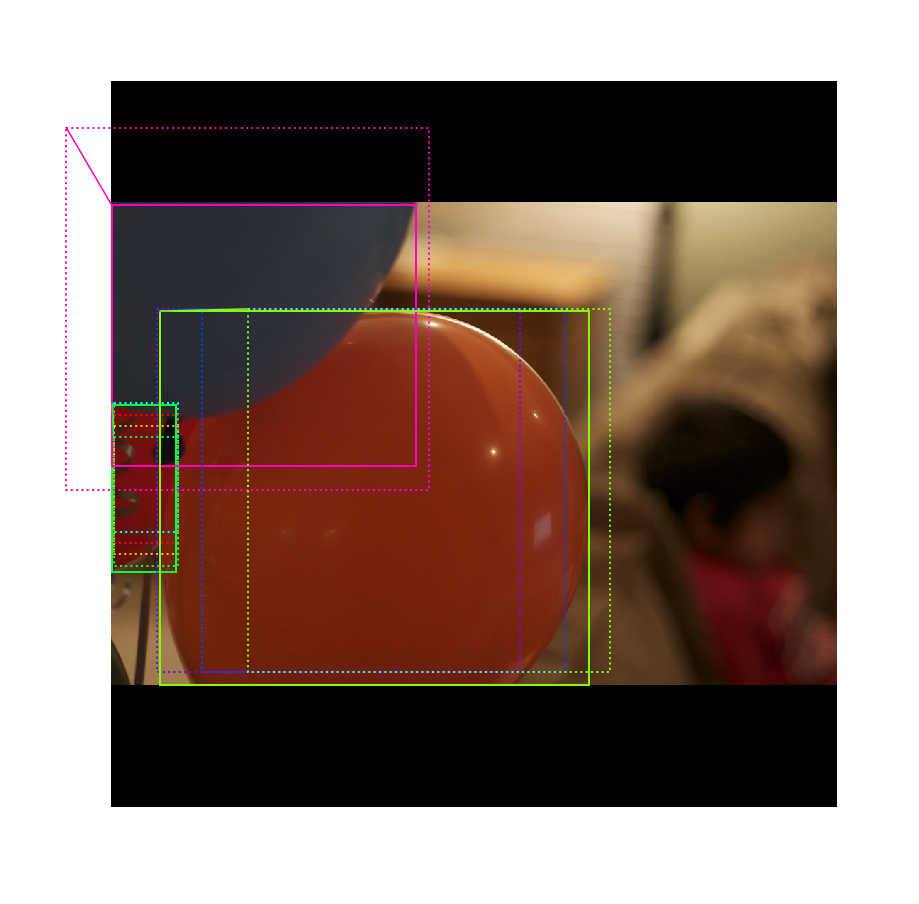

In [56]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

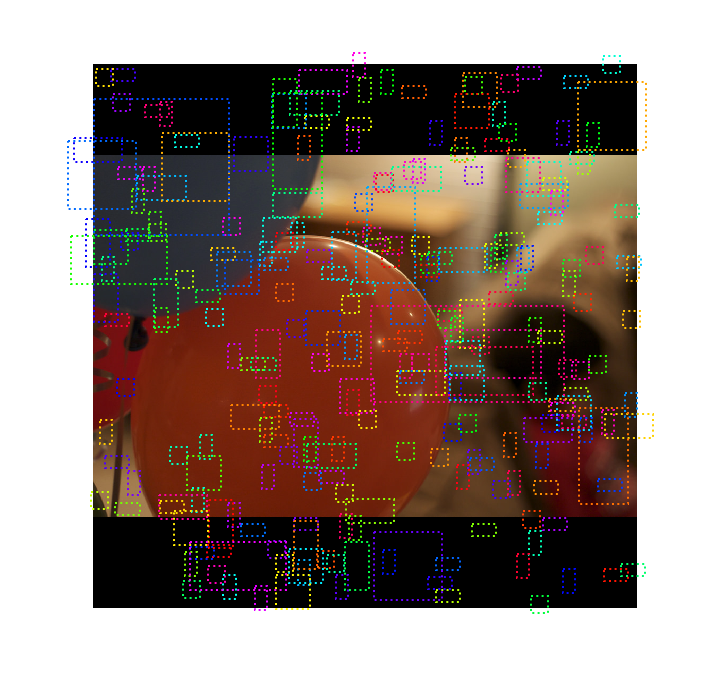

In [57]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

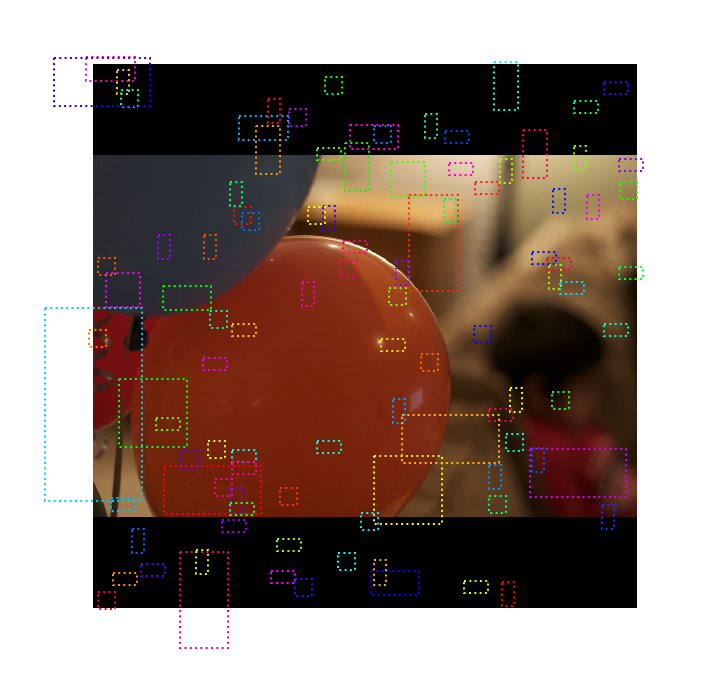

In [58]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  66
Negative ROIs:  134
Positive Ratio: 0.33
Unique ROIs: 200 out of 200


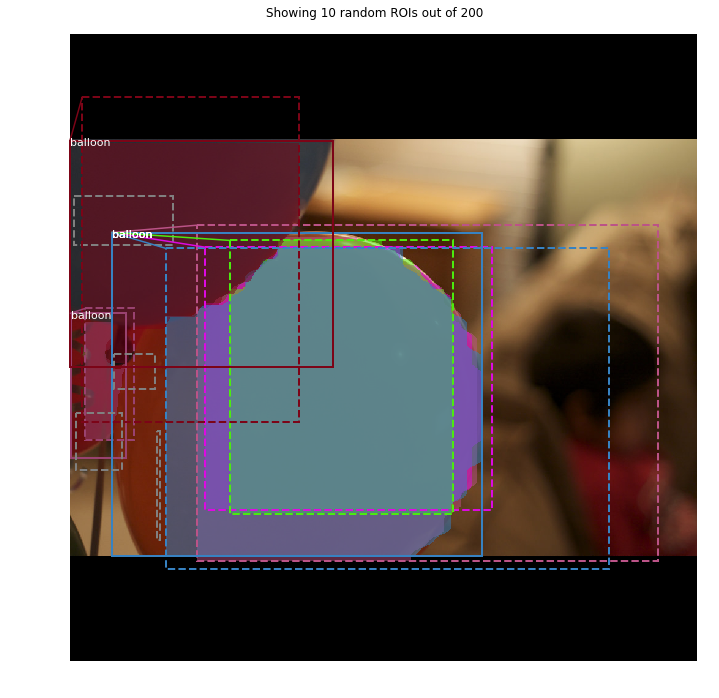

In [59]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

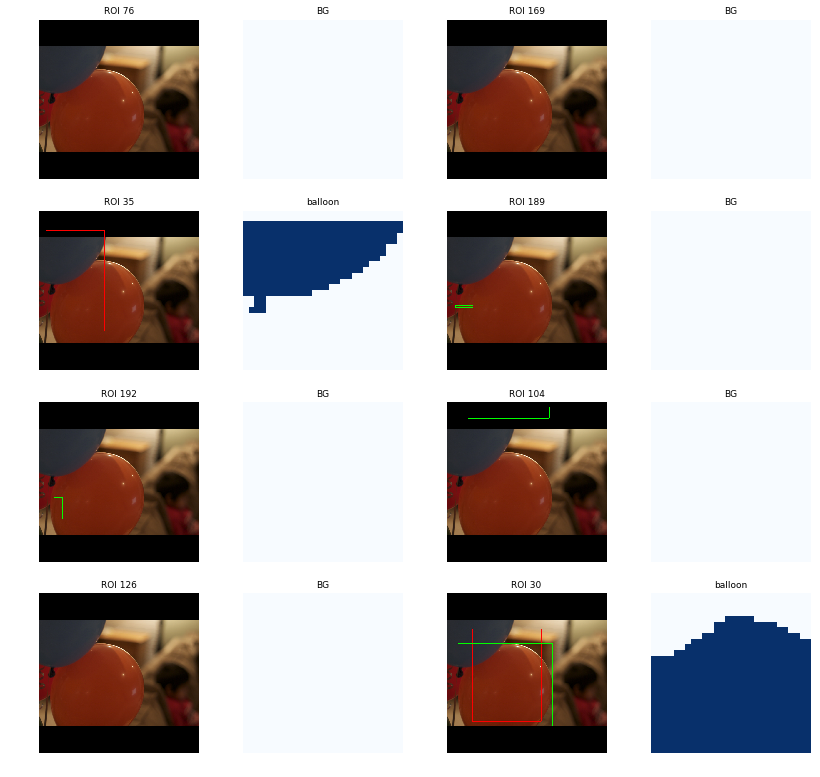

In [60]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [61]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
